<a href="https://colab.research.google.com/github/flediak/genIAL/blob/main/make_gal_shapes.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Intro

This notebook shows how to model intrinsic galaxy shapes using genIAL, when information on host halo orientations is not avialable.
Galaxy orientations are thereby set to random.

# clone genIAL repository and import libraries

In [1]:
! git clone https://github.com/flediak/genIAL.git

fatal: destination path 'genIAL' already exists and is not an empty directory.


In [2]:
cd genIAL

/content/genIAL


In [3]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from genial import Galaxy, IntrinsicAlignment

# download input galaxy catalogue

In [4]:
!gdown 1CqboAhfDqNraH-V0WW3D7DX5ctMc17tl -O input_file.parquet

#when not working on google colab use:
#!wget --no-check-certificate 'https://docs.google.com/uc?export=download&id=1CqboAhfDqNraH-V0WW3D7DX5ctMc17tl' -O ../data/input_file.parquet

Downloading...
From: https://drive.google.com/uc?id=1CqboAhfDqNraH-V0WW3D7DX5ctMc17tl
To: /content/genIAL/input_file.parquet
100% 33.3M/33.3M [00:00<00:00, 161MB/s] 


# download shape parameter file

In [5]:
!gdown 1F6-XasMtdVk6BuR5TN8GnMc-AiUgu3Mf -O ia_shape_parameters.csv

#when not working on google colab use:
#!wget --no-check-certificate 'https://docs.google.com/uc?export=download&id=1F6-XasMtdVk6BuR5TN8GnMc-AiUgu3Mf' -O ia_shape_parameters.csv

Downloading...
From: https://drive.google.com/uc?id=1F6-XasMtdVk6BuR5TN8GnMc-AiUgu3Mf
To: /content/genIAL/ia_shape_parameters.csv
100% 2.00M/2.00M [00:00<00:00, 36.9MB/s]


# set up shape model parameters

In [6]:
# Hoffman et al. 2022 color cut for MICECAT2
ia_ur_cut = 0.94

# read input table with shape model parameters
with open('ia_shape_parameters.csv') as fd:
    ia_params = pd.read_csv(fd, header=0)
    ia_params.loc[ia_params['gal_color']==2.0, 'gal_color'] = Galaxy.Color.BLUE.value
    ia_params.loc[ia_params['gal_color']==0.0, 'gal_color'] = Galaxy.Color.RED.value
    ia_params = ia_params.set_index(['gal_color', 'z', 'mag']).sort_index()[['q_mean', 'r_mean', 'sigma']]

# instantiate IA class

In [7]:
ia = IntrinsicAlignment(ia_params)

# shape model pipeline

In [8]:
def make_gal_shapes(df, ia_ur_cut):
    
    # use this color index for red blue definitions
    ia_ur = df['cfht_u_abs_mag'] - df['subaru_r_abs_mag']

    # define blue / red IDs
    ia_color = np.where(
        ia_ur < ia_ur_cut,
        Galaxy.Color.BLUE.value,
        Galaxy.Color.RED.value
    ).astype('i1')


    ### ====== set 3D axis ratios (q=B/A, s=C/A) ======
    qg, sg = ia.axis_ratio(ia_color, df['true_redshift_gal'].values, df['subaru_r_abs_mag'].values)

    ### ====== set random galaxy positions and orientations ======    
    vg = ia._random_vector(len(df)) #position
    Ag = ia._random_vector(len(df)) # major axis
    Cg = ia._random_perpendicular(Ag) # minor axis

    ### ====== get ellipticity ======
    eps1, eps2 = ia.ellipticity(vg, qg, sg, Ag, Cg)


    return qg, sg, eps1, eps2

# read input catalogue

In [9]:
cat = pd.read_parquet('input_file.parquet').iloc[0:20000] #read first N lines

# make shapes

In [10]:
cat['q_gal'], cat['s_gal'], cat['eps1_gal'], cat['eps2_gal'] = make_gal_shapes(cat, ia_ur_cut)

# plot 2D axis ratio distributions

In [11]:
# get absolute value of ellipticity and convert to 2D axis ratio
eps_abs = (cat['eps1_gal']**2 + cat['eps2_gal']**2)**0.5
cat['q_proj'] = (1-eps_abs) / (1+eps_abs)

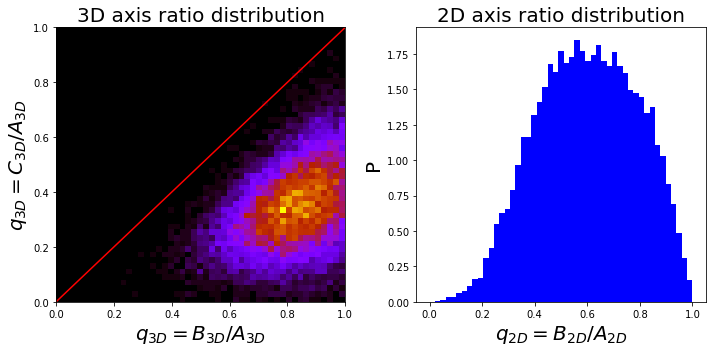

In [12]:
fig, ax = plt.subplots(1,2, figsize=(10,5))

fontsize=20

qbins = np.linspace(0,1,50)
sbins = qbins

# plot 3D axix ratios
ax[0].set_title('3D axis ratio distribution', fontsize=fontsize)
ax[0].hist2d(cat.q_gal, cat.s_gal, bins=[qbins, sbins], density=True, cmap='gnuplot')
ax[0].set_xlabel(r'$q_{3D} = B_{3D}/A_{3D}$', fontsize=fontsize)
ax[0].set_ylabel(r'$q_{3D} = C_{3D}/A_{3D}$', fontsize=fontsize)

x = np.linspace(0,1,100)
ax[0].plot(x,x,c='r')

# plot 2D axix ratios
ax[1].set_title('2D axis ratio distribution',fontsize=fontsize)
ax[1].hist(cat.q_proj, bins=qbins, density=True, color='b')
ax[1].set_xlabel(r'$q_{2D} = B_{2D}/A_{2D}$', fontsize=fontsize)
ax[1].set_ylabel('P', fontsize=fontsize)

plt.tight_layout()
plt.show()